# **Stage 1: Loading the Data set** 

In [1]:
import zipfile

DATASET_PATH = "content/gtsrb"

TRAIN_DATA = f"{DATASET_PATH}/Train"

#with zipfile.ZipFile("gtsrb.zip",'r') as zip_ref:
#    print("Skipped")
    #zip_ref.extractall("content/gtsrb")

# **Stage 2: Data sorting and labeling**

In [2]:
import os

image_paths = []
labels = []

for folder_class_name in os.listdir(TRAIN_DATA):            #folder_class_name = 0 1 2 ..... 42
    class_dir = os.path.join(TRAIN_DATA, folder_class_name) #content/gtsrb/Train\0 1 2 . .... 42

    #Check if the path exixts. If not the skip it and go for next folder_class_name
    if not os.path.isdir(class_dir):
        continue

    for img_file in os.listdir(class_dir):
        full_path = os.path.join(class_dir, img_file)       #content/gtsrb/Train\0 1 2....42\00000_00000_00000.png... 0001234
        image_paths.append(full_path)
        labels.append(int(folder_class_name))

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

data_df = pd.DataFrame(
  {
    "image_path": image_paths,
    "label": labels
  }
)
print("Total Images: "+str(len(data_df.image_path)))
print("Total Labels: "+str(len(data_df["label"] .unique())))

train_data_df, temp_data_df = train_test_split(
    data_df,
    test_size=0.4,
    stratify = data_df['label'],
    random_state = 42
)

# Here the entire test data (temp_data_df) from above is split half into validation and test data
test_data_df, valtest_data_df = train_test_split(
    temp_data_df,
    test_size=0.35,
    stratify=temp_data_df['label'],
    random_state=42
 )

Total Images: 39209
Total Labels: 43


# **Stage 3: Helper functions/methods development**
These are the methods and functions required to prepare the data to load on to custom CNN model and tranfer learning Reset50 model  

In [4]:
!pip install tensorflow

In [5]:
import cv2
import numpy as np
#!pip install -U protobuf==3.20.3
from tensorflow.keras.utils import to_categorical

IMG_SIZE = 32
NUM_CLASSES = 43



def encode_label(label):
    return to_categorical(label, NUM_CLASSES)




def normalize_image(img):
    # Conver the pixels from (0 - 255) to (0.0 - 1.0)
    return img / 255.0




def load_and_resize_image(img_path):
    # Load the image
    img = cv2.imread(img_path)

    if img is None:
        raise FileNotFoundError(f"Image not found at path: {img_path}")

    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the size to 32x32
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

    return img




def load_and_resize_image_ResNet50(img_path):
    # Load the image
    img = cv2.imread(img_path)

    if img is None:
        raise FileNotFoundError(f"Image not found at path: {img_path}")
    
    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the size to 32x32
    img = cv2.resize(img, (128,128))
    
    return img




def prepare_image_generator(dataframe_df, gen_batch_size = 32, model = None):
    
        for start in range(0, len(dataframe_df), gen_batch_size):
            images = []
            labels = []
            batch_df = dataframe_df[start:start+gen_batch_size]

            '''for image_index_tuple in batch_df.iterrows():
              
              image_index_tuple[0] = index = 31367
              image_index_tuple[1] = 
              31367
              image_path    content/gtsrb/Train\12\00012_00031_00018.png
              label                                                   12
              Name: 6708, dtype: object

              image_index_tuple[1]['image_path'] = content/gtsrb/Train\12\00012_00031_00018.png
              image_index_tuple[1]['lable'] = 12
              '''
            for index, row in batch_df.iterrows():
              
              if row['image_path'] is None or row['image_path'] == '':
                  continue
              if row['label'] == None:
                  continue
              
              df_img_path = row['image_path']
              df_img_label = row['label']
              if model == 'custom_cnn':
                  img = load_and_resize_image(df_img_path)
              else:
                  img = load_and_resize_image_ResNet50(df_img_path)  

              if img is None:
                 continue
              
              img = normalize_image(img)

              images.append(img)
              labels.append(df_img_label)
            
            if len(images) > 0:
                gen_images = np.array(images)
                gen_labels = encode_label(labels)
                yield gen_images, gen_labels

c:\Users\risha\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


# **Stage 4: Load the previously developed Custom CNN Model and Resnet50 model**  

In [6]:
from tensorflow.keras.models import load_model
import joblib

In [7]:
# Load CNN model
custom_cnn = load_model(r"models\complete_models\custom_cnn\custom_cnn_model.h5")

# Load ResNet50 model
resnet50 = load_model(r"models\complete_models\resnet50\resnet50_model.h5")

print(custom_cnn.summary())
print(resnet50.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 361,069 (1.38 MB)

 Trainable params: 361,067 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 23,721,645 (90.49 MB)

 Trainable params: 4,599,595 (17.55 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

 Optimizer params: 2 (12.00 B)

None


# **Stage 5: Predict probabilty for above models**
 **probs_cnn**: Stores the probabilties of all images provided to Custom CNN model  
 **probs_resnet50**: Stores the probabilties of all images provided to Resnet50 model (Tranfer learning)

In [8]:
# CNN predictions
probs_cnn = []
train_labels = []
gen_batch_size = 224
train_images_generator = prepare_image_generator(train_data_df, gen_batch_size, model='custom_cnn')
for image_batch, labels in train_images_generator:
    probs_cnn.append(custom_cnn.predict(image_batch))
    train_labels.append(labels)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━

In [9]:
probs_cnn = np.vstack(probs_cnn)
train_labels = np.vstack(train_labels)

In [10]:

print("The number of images used for predicting "+ str(len(probs_cnn)))

The number of images used for predicting 23525


In [11]:
# Predict the classes in batches of 224

# It will run around 107 to 108 times since 128*128*3 resolution 
# is too much to store and provide in single call
probs_resnet50 = []
gen_batch_size = 224
train_images_generator = prepare_image_generator(train_data_df, gen_batch_size, model='resnet50')
for image_batch, labels in train_images_generator:
    probs_resnet50.append(resnet50.predict(image_batch))

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 304ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 281ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 293ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 306ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 288ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 296ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 289ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 258ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 257ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 258ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 258ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 

In [12]:
# Stack all batches into a single 2D array
probs_resnet50 = np.vstack(probs_resnet50)
probs_cnn = np.vstack(probs_cnn)

In [13]:
# Concatenate features/probailities from the two models
probs_stack  = np.hstack([probs_cnn,probs_resnet50])
label_stack = train_labels

# Labels normalised and encodes
label_stack = np.argmax(train_labels, axis=1)

# Note that the sample size of bothe should be same

# **Stage 6: Train the Meta learner [Logistic Regression] from the prdictions of the above models**  
Note: Since Keras dont have Logistic Regression explicilty, a model with Sequenct and activation should be created  

Below the Logistric regression is implemented as follows:  
Input = 86 numbers which are the 86 probalities from two models above.  
Output = 43 probabilities (nomrmalised to 1).  
Training = the model learns weights for each input feature to best predict the correct class.  
There are no hidden layers, the below implementation is the Keras version of Logistic Regression  

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

In [15]:
meta_lr = Sequential([
    Input(shape=(86,)),
    Dense(43, activation='softmax')
    ])

In [16]:
meta_lr.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [17]:
history = meta_lr.fit(
    probs_stack,
    label_stack,
    epochs = 10,
    batch_size = 32,
    validation_split=0.1
)

Epoch 1/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7261 - loss: 2.9187 - val_accuracy: 0.9435 - val_loss: 2.1292
Epoch 2/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9659 - loss: 1.5728 - val_accuracy: 0.9779 - val_loss: 1.1033
Epoch 3/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9808 - loss: 0.8384 - val_accuracy: 0.9856 - val_loss: 0.6073
Epoch 4/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9891 - loss: 0.4830 - val_accuracy: 0.9928 - val_loss: 0.3630
Epoch 5/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9944 - loss: 0.2997 - val_accuracy: 0.9962 - val_loss: 0.2326
Epoch 6/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9966 - loss: 0.1977 - val_accuracy: 0.9979 - val_loss: 0.1575
Epoch 7/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9978 - loss: 0.1370 - val_accuracy: 0.9987 - val_loss: 0.1115
Epoch 8/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9982 - loss: 0.0986 - val_accuracy: 0.

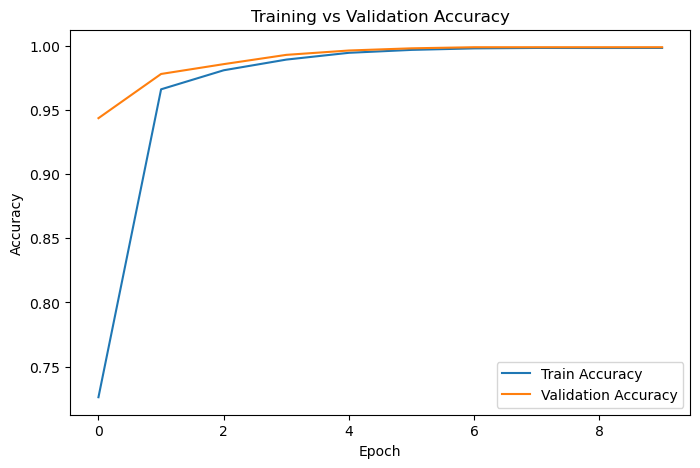

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.savefig(r"outputs\Training_vs_Validation_Accuracy_metalearner.pdf", dpi=300)
plt.show()

In [19]:
os.makedirs(r"models\weights\meta_learner", exist_ok=True)
os.makedirs(r"models\complete_models\meta_learner", exist_ok=True)


# Save only weights
meta_lr.save_weights(r"models\weights\meta_learner\meta_learner_model.weights.h5")

# Or save the full model (architecture + weights + optimizer)
meta_lr.save(r"models\complete_models\meta_learner\meta_learner_model.h5")